In [46]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, f1_score

# Titanic Classifier

In [51]:
import seaborn as sns

import random


# Concatenate features and target
full_data = sns.load_dataset('titanic')

full_data = full_data.drop(['alive'],axis=1)


# Split the dataset into out-of-sample (oos) and remaining data
random_indices = random.sample(range(len(full_data)), int(0.3 * len(full_data)))  # Get 30% random indices
data_oos = full_data.iloc[random_indices].copy()  # Select rows based on random indices
data_oos = data_oos.reset_index(drop=True)

# Update the original dataset to exclude the selected out-of-sample rows
full_data = full_data.drop(data_oos.index)


full_data

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alone
267,1,3,male,25.0,1,0,7.7750,S,Third,man,True,NaN,Southampton,False
268,1,1,female,58.0,0,1,153.4625,S,First,woman,False,C,Southampton,False
269,1,1,female,35.0,0,0,135.6333,S,First,woman,False,C,Southampton,True
270,0,1,male,NaN,0,0,31.0000,S,First,man,True,NaN,Southampton,True
271,1,3,male,25.0,0,0,0.0000,S,Third,man,True,NaN,Southampton,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,S,Second,man,True,NaN,Southampton,True
887,1,1,female,19.0,0,0,30.0000,S,First,woman,False,B,Southampton,True
888,0,3,female,NaN,1,2,23.4500,S,Third,woman,False,NaN,Southampton,False
889,1,1,male,26.0,0,0,30.0000,C,First,man,True,C,Cherbourg,True


In [60]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 624 entries, 267 to 890
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     624 non-null    int64   
 1   pclass       624 non-null    int64   
 2   sex          624 non-null    object  
 3   age          499 non-null    float64 
 4   sibsp        624 non-null    int64   
 5   parch        624 non-null    int64   
 6   fare         624 non-null    float64 
 7   embarked     623 non-null    object  
 8   class        624 non-null    category
 9   who          624 non-null    object  
 10  adult_male   624 non-null    bool    
 11  deck         150 non-null    category
 12  embark_town  623 non-null    object  
 13  alone        624 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(4)
memory usage: 51.8+ KB


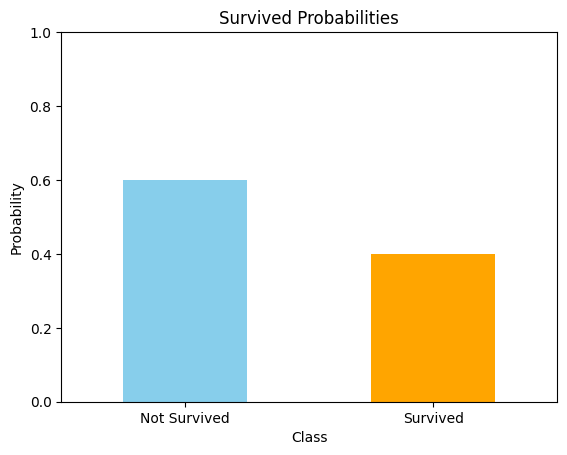

In [3]:
import matplotlib.pyplot as plt


# Convert target to a pandas Series
y = pd.Series(full_data.survived, name='survived')

# Calculate the relative frequencies (probabilities)
target_probabilities = y.value_counts(normalize=True)

# Plot the bar chart
target_probabilities.plot(kind='bar', color=['skyblue', 'orange'])
plt.title('Survived Probabilities')
plt.xlabel('Class')
plt.ylabel('Probability')
plt.xticks(ticks=[0, 1], labels=['Not Survived', 'Survived'], rotation=0)  # Use meaningful labels
plt.ylim(0, 1)  # Ensure y-axis is in probability range
plt.show()

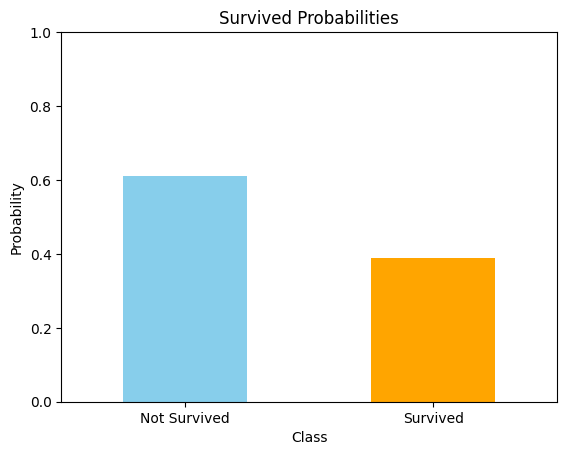

In [7]:
import matplotlib.pyplot as plt


# Convert target to a pandas Series
y = pd.Series(data_oos.survived, name='survived')

# Calculate the relative frequencies (probabilities)
target_probabilities = y.value_counts(normalize=True)

# Plot the bar chart
target_probabilities.plot(kind='bar', color=['skyblue', 'orange'])
plt.title('Survived Probabilities')
plt.xlabel('Class')
plt.ylabel('Probability')
plt.xticks(ticks=[0, 1], labels=['Not Survived', 'Survived'], rotation=0)  # Use meaningful labels
plt.ylim(0, 1)  # Ensure y-axis is in probability range
plt.show()

In [4]:
from sklearn.model_selection import train_test_split

# Assuming 'full_data' contains both features and the target column
# Separate features and target

label = 'survived'

X = full_data.drop(columns=[label])  # Replace 'target' with the actual target column name
y = full_data[label]

# Split the dataset into train and test sets with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,  # 20% test set
    random_state=42,  # For reproducibility
    stratify=y  # Ensures class distribution is maintained
)

# Combine X and y back for train and test if needed as DataFrames
train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

train_df[label] = train_df[label].astype(float)
test_df[label] = test_df[label].astype(float)


test_df = test_df.reset_index(drop=True)
train_df = train_df.reset_index(drop=True)

# Display class distributions to verify
print("Train set class distribution:\n", y_train.value_counts(normalize=True))
print("Test set class distribution:\n", y_test.value_counts(normalize=True))


Train set class distribution:
 survived
0    0.599198
1    0.400802
Name: proportion, dtype: float64
Test set class distribution:
 survived
0    0.6
1    0.4
Name: proportion, dtype: float64


In [13]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499 entries, 0 to 498
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   pclass       499 non-null    int64   
 1   sex          499 non-null    object  
 2   age          400 non-null    float64 
 3   sibsp        499 non-null    int64   
 4   parch        499 non-null    int64   
 5   fare         499 non-null    float64 
 6   embarked     498 non-null    object  
 7   class        499 non-null    category
 8   who          499 non-null    object  
 9   adult_male   499 non-null    bool    
 10  deck         116 non-null    category
 11  embark_town  498 non-null    object  
 12  alone        499 non-null    bool    
 13  survived     499 non-null    float64 
dtypes: bool(2), category(2), float64(3), int64(3), object(4)
memory usage: 41.5+ KB


In [5]:
from feature_engine.selection import DropFeatures
from feature_engine.imputation import MeanMedianImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


In [19]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499 entries, 0 to 498
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   pclass       499 non-null    object 
 1   sex          499 non-null    object 
 2   age          400 non-null    float64
 3   sibsp        499 non-null    object 
 4   parch        499 non-null    object 
 5   fare         499 non-null    float64
 6   embarked     498 non-null    object 
 7   class        499 non-null    object 
 8   who          499 non-null    object 
 9   adult_male   499 non-null    object 
 10  deck         116 non-null    object 
 11  embark_town  498 non-null    object 
 12  alone        499 non-null    object 
 13  survived     499 non-null    float64
dtypes: float64(3), object(11)
memory usage: 54.7+ KB


In [9]:
# I know that feature_engine package in python is the tune that can automatically create a pipeline to preprocessing the data. I want to create a pipeline for numerical features as follow. 

# Step 1: Given dataframe, choose the columns that has type float
# Step 2: Fillna as mean value 
# Step 3: perform standardized scale fit on the numerical features

# The pipeline can be fit and transform to the new dataset and note that all other columns that has type different from float is drop


float_cols = train_df.select_dtypes(include=['float']).columns.tolist()
non_float_cols = [col for col in train_df.columns if col not in float_cols]



# Define the pipeline
pipeline = Pipeline([
    ('drop_non_float', DropFeatures(features_to_drop=non_float_cols+[label])),  # Drop non-float columns
    ('imputer', MeanMedianImputer(imputation_method='mean')),  # Step 2: Fillna with mean
    ('scaler', StandardScaler())  # Step 3: Standardize numerical features
])


processed_data = pipeline.fit_transform(train_df)
val_proceess = pipeline.transform(test_df)
val_proceess


array([[-8.28105175e-01, -5.19122088e-01],
       [ 1.45243287e+00,  1.57059804e+00],
       [-1.81633833e+00, -9.73257968e-03],
       [-7.52087240e-01, -5.03564973e-01],
       [-9.80141045e-01, -5.32648074e-01],
       [ 0.00000000e+00, -5.15993215e-01],
       [ 1.60127979e-01, -5.18529591e-01],
       [ 3.12163849e-01, -5.15993215e-01],
       [ 0.00000000e+00, -9.73257968e-03],
       [ 8.09210918e-03, -5.32226021e-01],
       [ 0.00000000e+00, -5.19458919e-01],
       [-1.43624865e+00, -2.98118523e-01],
       [ 0.00000000e+00, -3.52650605e-01],
       [-5.24033435e-01, -4.45989239e-01],
       [-8.28105175e-01, -5.19122088e-01],
       [ 0.00000000e+00, -5.15993215e-01],
       [ 1.45243287e+00, -1.53206235e-01],
       [-2.95979631e-01, -1.51769632e-01],
       [-1.43943761e-01, -4.05407225e-01],
       [ 5.40217654e-01, -7.66929042e-02],
       [ 2.13659429e+00, -7.66929042e-02],
       [-6.00051370e-01, -4.65941387e-01],
       [ 1.83252255e+00,  5.25950017e-01],
       [ 2.

In [24]:
from feature_engine.selection import DropFeatures
from feature_engine.imputation import CategoricalImputer
from feature_engine.encoding import OneHotEncoder

float_cols = train_df.select_dtypes(include=['float']).columns.tolist()
non_float_cols = [col for col in train_df.columns if col not in float_cols]

train_df[non_float_cols] = train_df[non_float_cols].astype('str')

# Step 1: Define the pipeline
preprocessing_pipeline = Pipeline([
    # Drop float columns first
    ('drop_float_cols', DropFeatures(features_to_drop=float_cols)),  # Placeholders, dynamically set later
    
    # Step 2: Impute missing values using the most frequent value
    ('imputer', CategoricalImputer(imputation_method="frequent")),
    
    # Step 3: One-hot encode and drop one category
    ('one_hot_encoder', OneHotEncoder(drop_last=True))
])

processed_data = preprocessing_pipeline.fit_transform(train_df)
processed_data


,pclass_3,pclass_1,sex_female,sibsp_0,sibsp_2,sibsp_1,sibsp_3,sibsp_5,sibsp_8,parch_3,...,deck_B,deck_A,deck_C,deck_D,deck_E,deck_F,embark_town_Cherbourg,embark_town_Southampton,embark_town_Queenstown,alone_False
0,1,0,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,1
1,0,1,1,0,1,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,1
2,0,1,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
3,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
4,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494,1,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
495,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
496,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
497,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [29]:
test_df[non_float_cols] = test_df[non_float_cols].astype('str')

preprocessing_pipeline.transform(test_df)

,pclass_3,pclass_1,sex_female,sibsp_0,sibsp_2,sibsp_1,sibsp_3,sibsp_5,sibsp_8,parch_3,...,deck_B,deck_A,deck_C,deck_D,deck_E,deck_F,embark_town_Cherbourg,embark_town_Southampton,embark_town_Queenstown,alone_False
0,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,1,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,1,0,0,1
2,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
3,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120,1,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
121,1,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,1
122,0,1,1,1,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
123,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1


In [26]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499 entries, 0 to 498
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   pclass       499 non-null    object 
 1   sex          499 non-null    object 
 2   age          400 non-null    float64
 3   sibsp        499 non-null    object 
 4   parch        499 non-null    object 
 5   fare         499 non-null    float64
 6   embarked     499 non-null    object 
 7   class        499 non-null    object 
 8   who          499 non-null    object 
 9   adult_male   499 non-null    object 
 10  deck         499 non-null    object 
 11  embark_town  499 non-null    object 
 12  alone        499 non-null    object 
 13  survived     499 non-null    float64
dtypes: float64(3), object(11)
memory usage: 54.7+ KB


# Trainning the MLP

Data Preprocessing

In [11]:
from sklearn.preprocessing import StandardScaler


In [35]:
class TitanicData(d2l.DataModule):
    def __init__(self,batch_size,train=None,val=None):
        super().__init__()
        self.save_hyperparameters()
        if self.train is None:
            self.raw_train = train_df
            self.raw_val = test_df
        self.label = 'survived'

@d2l.add_to_class(TitanicData)
def preprocess_numerical(self,train_df,val_df):
    float_cols = train_df.select_dtypes(include=['float']).columns.tolist()
    float_cols.remove(label)
    non_float_cols = [col for col in train_df.columns if col not in float_cols]

    self.num_pipe =  Pipeline([
    ('drop_non_float', DropFeatures(features_to_drop=non_float_cols+[label])),  # Drop non-float columns
    ('imputer', MeanMedianImputer(imputation_method='mean')),  # Step 2: Fillna with mean
    ('scaler', StandardScaler())  # Step 3: Standardize numerical features
])

    processed_num_train = self.num_pipe.fit_transform(train_df)
    processed_num_test = self.num_pipe.transform(val_df)

    processed_num_train = pd.DataFrame(processed_num_train, columns=float_cols)
    processed_num_test = pd.DataFrame(processed_num_test, columns=float_cols)

    return processed_num_train,processed_num_test


@d2l.add_to_class(TitanicData)
def preprocess_categorical(self,train_df,val_df):


    float_cols = train_df.select_dtypes(include=['float']).columns.tolist()
    non_float_cols = [col for col in train_df.columns if col not in float_cols]

    train_df[non_float_cols] = train_df[non_float_cols].astype('str')
    val_df[non_float_cols] = val_df[non_float_cols].astype('str')


    # Step 1: Define the pipeline
    self.cat_pipe = Pipeline([
        # Drop float columns first
        ('drop_float_cols', DropFeatures(features_to_drop=float_cols)),  # Placeholders, dynamically set later
        
        # Step 2: Impute missing values using the most frequent value
        ('imputer', CategoricalImputer(imputation_method="frequent")),
        
        # Step 3: One-hot encode and drop one category
        ('one_hot_encoder', OneHotEncoder(drop_last=True))
    ])

    processed_cat_train = self.cat_pipe.fit_transform(train_df)
    processed_cat_test = self.cat_pipe.transform(val_df)


    return processed_cat_train,processed_cat_test

    
    



@d2l.add_to_class(TitanicData)
def preprocess(self):
    # Remove the ID and label columns
    label = self.label
    processed_num_train,processed_num_test = self.preprocess_numerical(self.raw_train,self.raw_val)
    processed_cat_train,processed_cat_test = self.preprocess_categorical(self.raw_train,self.raw_val)

    
    # Save preprocessed features
    self.train = pd.concat([processed_num_train,processed_cat_train],axis=1)
    self.train[label] = self.raw_train[label].reset_index(drop=True)
    
    self.val = pd.concat([processed_num_test,processed_cat_test],axis=1)
    self.val[label] = self.raw_val[label].reset_index(drop=True)

@d2l.add_to_class(TitanicData)
def get_dataloader(self, train):
    label = self.label
    data = self.train if train else self.val
    if label not in data: return
    get_tensor = lambda x: torch.tensor(x.values.astype(float),
                                      dtype=torch.float32)
    # Logarithm of prices
    tensors = (get_tensor(data.drop(columns=[label])),  # X
             get_tensor(data[label]))  # Y
    return self.get_tensorloader(tensors, train)

@d2l.add_to_class(TitanicData)
def get_tensorloader(self, tensors, train):
    dataset = torch.utils.data.TensorDataset(*tensors)
    return torch.utils.data.DataLoader(dataset, batch_size=self.batch_size, shuffle=train)



data = TitanicData(batch_size=20)
data.preprocess()
print(data.train.shape)
print(data.val.shape)

(499, 37)
(125, 37)


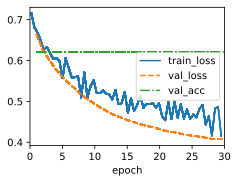

In [36]:
# Define the MLP model
class MLP(d2l.Classifier):
    def __init__(self, num_outputs, num_hiddens, dropout_1, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.LazyLinear(num_hiddens),
            nn.ReLU(),
            nn.Dropout(dropout_1),
            nn.LazyLinear(num_outputs)
        )
        self.loss_fn = nn.BCEWithLogitsLoss()  # Use BCE loss with logits

    def loss(self, y_hat, y):
        """Custom loss function"""
        return self.loss_fn(y_hat.squeeze(1), y.float())  # Squee



# Instantiate the model
model = MLP(num_outputs=1, num_hiddens=250, dropout_1=0.5, lr=0.01)
# model = MLP(num_outputs=1, num_hiddens=250, lr=0.01)

trainer = d2l.Trainer(max_epochs=30)
trainer.fit(model,data)

Cross Validation

In [44]:
def k_fold_data(data, k):
    rets = []
    fold_size = data.train.shape[0] // k
    for j in range(k):
        idx = range(j * fold_size, (j+1) * fold_size)
        rets.append(TitanicData(data.batch_size, data.train.drop(index=idx),
                                data.train.loc[idx]))
    return rets


def k_fold(trainer, data, k, num_outputs=1, num_hiddens=250, dropout_1=0.5, lr=0.01):
    val_loss, val_accuracy, models = [], [], []
    
    for i, data_fold in enumerate(k_fold_data(data, k)):
        print(f'In the iteration {i+1}')
        
        # Initialize the model for the current fold
        model = MLP(num_outputs=num_outputs, num_hiddens=num_hiddens, dropout_1=dropout_1, lr=lr)
        model.board.yscale = 'log'  # Log scale for loss visualization
        if i != 0:
            model.board.display = False
        
        # Train the model
        trainer.fit(model, data_fold)
        
        # Get final validation loss
        final_val_loss = float(model.board.data['val_loss'][-1].y)
        val_loss.append(final_val_loss)
        
        # Evaluate accuracy on the validation set
        val_data = data_fold.val
        y_true = val_data['survived'].values  # True labels
        
        # Convert validation features to a tensor
        val_features = torch.tensor(val_data.drop(columns=['survived']).values, dtype=torch.float32)
        y_pred_logits = model(val_features)  # Predicted logits
        y_pred = (torch.sigmoid(y_pred_logits).detach().numpy() > 0.5).astype(int)  # Convert to binary predictions
        
        # Compute accuracy
        accuracy = accuracy_score(y_true, y_pred)
        val_accuracy.append(accuracy)
        
        print(f"Fold {i+1} - Validation Loss: {final_val_loss:.4f}, Validation Accuracy: {accuracy:.4f}")
        models.append(model)
    
    # Print average metrics across all folds
    avg_loss = sum(val_loss) / len(val_loss)
    avg_accuracy = sum(val_accuracy) / len(val_accuracy)
    print(f"Average Validation Log Loss: {avg_loss:.4f}")
    print(f"Average Validation Accuracy: {avg_accuracy:.4f}")
    
    return models


In [78]:
trainer = d2l.Trainer(max_epochs=100)
models = k_fold(trainer, data, k=5,num_outputs=1, num_hiddens=250, dropout_1=0.5,lr=0.01)

Fold 1 - Validation Loss: 0.4086, Validation Accuracy: 0.8182
In the iteration 2


/Users/khai/opt/anaconda3/envs/nest/lib/python3.11/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Fold 2 - Validation Loss: 0.4925, Validation Accuracy: 0.7475
In the iteration 3


/Users/khai/opt/anaconda3/envs/nest/lib/python3.11/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Fold 3 - Validation Loss: 0.3422, Validation Accuracy: 0.8788
In the iteration 4


/Users/khai/opt/anaconda3/envs/nest/lib/python3.11/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Fold 4 - Validation Loss: 0.4974, Validation Accuracy: 0.8283
In the iteration 5


/Users/khai/opt/anaconda3/envs/nest/lib/python3.11/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Fold 5 - Validation Loss: 0.4641, Validation Accuracy: 0.7980
Average Validation Log Loss: 0.4410
Average Validation Accuracy: 0.8141


Predictions

In [79]:
@d2l.add_to_class(TitanicData)
def preprocess_new_data(self, new_data):
    # Ensure the new data is a DataFrame
    if not isinstance(new_data, pd.DataFrame):
        raise ValueError("new_data must be a pandas DataFrame.")
    
    label = self.label
    
    processed_num_train,processed_num_test = self.preprocess_numerical(self.raw_train,new_data)
    processed_cat_train,processed_cat_test = self.preprocess_categorical(self.raw_train,new_data)

    
    # Save preprocessed features
   
    
    new_data_scaled = pd.concat([processed_num_test,processed_cat_test],axis=1)
    # new_data_scaled[label] = new_data[label].reset_index(drop=True)

    return new_data_scaled

In [80]:
# Preprocess new data
new_data_scaled = data.preprocess_new_data(data_oos)

# Convert the preprocessed features to PyTorch tensor
new_data_tensor = torch.tensor(new_data_scaled.values.astype(float), dtype=torch.float32)

In [81]:
new_data_tensor.shape

torch.Size([267, 36])

In [73]:
data.val

,age,fare,pclass_3,pclass_1,sex_female,sibsp_0,sibsp_2,sibsp_1,sibsp_3,sibsp_5,...,deck_A,deck_C,deck_D,deck_E,deck_F,embark_town_Cherbourg,embark_town_Southampton,embark_town_Queenstown,alone_False,survived
0,-0.828105,-0.519122,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0.0
1,1.452433,1.570598,0,1,0,0,0,1,0,0,...,0,1,0,0,0,1,0,0,1,0.0
2,-1.816338,-0.009733,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,1,0,1,1.0
3,-0.752087,-0.503565,1,0,1,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0.0
4,-0.980141,-0.532648,1,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120,-0.371998,-0.518530,1,0,1,0,0,1,0,0,...,0,0,0,0,0,0,1,0,1,0.0
121,-2.044392,-0.251703,1,0,1,0,0,0,1,0,...,0,0,0,0,0,0,1,0,1,0.0
122,-0.448016,0.325154,0,1,1,1,0,0,0,0,...,0,1,0,0,0,1,0,0,0,1.0
123,-0.143944,-0.009733,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0.0


Prediction in Log Val

In [85]:
preds = [model(new_data_tensor) for model in models]
# Taking exponentiation of predictions in the logarithm scale
# ensemble_preds = torch.cat(preds, 1).mean(1)


ensemble_preds = 1 / (1 + torch.exp(-torch.cat(preds, 1)))

ensemble_preds = ensemble_preds.mean(1)

submission = pd.DataFrame({'survived':ensemble_preds.detach().numpy()})
submission

,survived
0,0.386591
1,0.346653
2,0.129407
3,0.112257
4,0.504464
...,...
262,0.146012
263,0.557501
264,0.565677
265,0.958213


In [86]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, f1_score

def evaluate_predictions(submission, data_oos, threshold=0.5):
    """
    Evaluate binary classification metrics: AUC, accuracy, F1-score, and precision.
    
    Args:
        submission (pd.DataFrame): DataFrame containing predicted probabilities in 'target' column.
        data_oos (pd.DataFrame): DataFrame containing true labels in 'target' column.
        threshold (float): Threshold to convert probabilities into binary predictions.
        
    Returns:
        dict: Dictionary with AUC, accuracy, F1-score, and precision.
    """
    # Extract predicted probabilities and true labels
    y_pred_prob = submission['survived'].values  # Probabilities
    y_true = data_oos['survived'].values         # True labels (binary)
    
    # Convert probabilities to binary predictions based on the threshold
    y_pred = (y_pred_prob > threshold).astype(int)
    
    # Calculate metrics
    auc = roc_auc_score(y_true, y_pred_prob)
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    
    # Return results in a dictionary
    return {
        "AUC": auc,
        "Accuracy": accuracy,
        "F1-Score": f1,
        "Precision": precision
    }

# Example Usage
metrics = evaluate_predictions(submission, data_oos)
print(metrics)


{'AUC': 0.8708700764256321, 'Accuracy': 0.8052434456928839, 'F1-Score': 0.7373737373737373, 'Precision': 0.7849462365591398}
